## Problem statement:
### Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

### Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

- Historical data of demand for a product-center combination (Weeks: 1 to 145)
- Product(Meal) features such as category, sub-category, current price and discount
- Information for fulfillment center like center area, city information etc.

## Tools and technologies used: 
* Python: Programming language
* Pandas: For data cleaning
* Matplotlib: For data visualisation
* sklearn: For model building

In [41]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor # Library to check multicollinearity

## Load dataset

In [ ]:
train_data_path = os.path.join("..","data", "raw", "train_data.csv")
test_data_path = os.path.join("..","data", "raw", "test_data.csv")
fullfilment_info_path = os.path.join("..","data", "raw", "fulfilment_center_info.csv")
meal_info_path = os.path.join("..","data", "raw", "meal_info.csv")

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
fullfilment_info = pd.read_csv(fullfilment_info_path)
meal_info = pd.read_csv(meal_info_path)

In [ ]:
train.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189


In [ ]:
test.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0


In [ ]:
fullfilment_info.head(3)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0


In [ ]:
meal_info.head(5)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


# Merging datasets to create train data

#### Merge train with fulfillment_info on center_id

In [ ]:
train_full=pd.merge(fullfilment_info, train, on='center_id',how='left')
train_full.head(3) 

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,11,679,56,TYPE_A,3.7,1103215,1,1885,136.83,136.83,0,0,959
1,11,679,56,TYPE_A,3.7,1093939,1,1993,133.89,133.89,0,0,1052
2,11,679,56,TYPE_A,3.7,1120771,1,2539,133.86,135.86,0,0,379


### Merge the result(train_full) with meal_info on meal_id

In [ ]:
final_train_df= pd.merge(meal_info, train_full, on='meal_id',how='left')
final_train_df.head(3)

,meal_id,category,cuisine,center_id,city_code,region_code,center_type,op_area,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,1103215,1,136.83,136.83,0,0,959
1,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,1091356,2,133.86,135.86,0,0,1054
2,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,1195933,3,135.86,133.86,0,0,891


### Drop column 'id'

In [ ]:
final_train_df=final_train_df.drop(['id'],axis=1)
final_train_df.head(3)

,meal_id,category,cuisine,center_id,city_code,region_code,center_type,op_area,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,1,136.83,136.83,0,0,959
1,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,2,133.86,135.86,0,0,1054
2,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,3,135.86,133.86,0,0,891


### Check shape of final train data.

In [ ]:
print("Number of rows in train data:",final_train_df.shape[0])
print("Number of columns in train data:",final_train_df.shape[1])

Number of rows in train data: 456548
Number of columns in train data: 14


# Merging datasets to create test data

#### Merge test with fulfillment_info on center_id

In [ ]:
test_full=pd.merge(fullfilment_info, test, on='center_id',how='left')
test_full.head(3) 

,center_id,city_code,region_code,center_type,op_area,id,week,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,11,679,56,TYPE_A,3.7,1098228,146,1885,158.17,157.17,0,0
1,11,679,56,TYPE_A,3.7,1101375,146,1993,159.14,159.14,0,0
2,11,679,56,TYPE_A,3.7,1400016,146,2539,159.11,158.11,0,0


### Merge the result(test_full) with meal_info on meal_id

In [ ]:
final_test_df=pd.merge(meal_info, test_full, on='meal_id',how='left')
final_test_df.tail(3) 

,meal_id,category,cuisine,center_id,city_code,region_code,center_type,op_area,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured
32570,1445,Seafood,Continental,51,638,56,TYPE_A,7.0,1004884,153,727.53,726.53,0,0
32571,1445,Seafood,Continental,51,638,56,TYPE_A,7.0,1292684,154,727.53,727.53,0,0
32572,1445,Seafood,Continental,51,638,56,TYPE_A,7.0,1181766,155,678.03,678.03,0,0


### Drop column 'id'

In [ ]:
final_test_df= final_test_df.drop(["id"], axis=1)
final_test_df.head(3)

,meal_id,category,cuisine,center_id,city_code,region_code,center_type,op_area,week,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,146,158.17,157.17,0,0
1,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,147,158.14,158.14,0,0
2,1885,Beverages,Thai,11,679,56,TYPE_A,3.7,148,157.17,158.17,0,0


### Check shape of final test data.

In [ ]:
print("Number of rows in test data:",final_test_df.shape[0])
print("Number of columns in test data:",final_test_df.shape[1])

Number of rows in test data: 32573
Number of columns in test data: 13


# Saving train and test data

In [ ]:
final_train_df.to_csv("../data/processed/final_train_df.csv", index=False)
final_test_df.to_csv("../data/processed/final_test_df.csv", index=False)

# Check column names and data types.

In [ ]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   meal_id                456548 non-null  int64  
 1   category               456548 non-null  object 
 2   cuisine                456548 non-null  object 
 3   center_id              456548 non-null  int64  
 4   city_code              456548 non-null  int64  
 5   region_code            456548 non-null  int64  
 6   center_type            456548 non-null  object 
 7   op_area                456548 non-null  float64
 8   week                   456548 non-null  int64  
 9   checkout_price         456548 non-null  float64
 10  base_price             456548 non-null  float64
 11  emailer_for_promotion  456548 non-null  int64  
 12  homepage_featured      456548 non-null  int64  
 13  num_orders             456548 non-null  int64  
dtypes: float64(3), int64(8), object(3)
m

In [ ]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   meal_id                32573 non-null  int64  
 1   category               32573 non-null  object 
 2   cuisine                32573 non-null  object 
 3   center_id              32573 non-null  int64  
 4   city_code              32573 non-null  int64  
 5   region_code            32573 non-null  int64  
 6   center_type            32573 non-null  object 
 7   op_area                32573 non-null  float64
 8   week                   32573 non-null  int64  
 9   checkout_price         32573 non-null  float64
 10  base_price             32573 non-null  float64
 11  emailer_for_promotion  32573 non-null  int64  
 12  homepage_featured      32573 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 3.2+ MB


# Summary statistics of numerical columns

### Train data

In [ ]:
final_train_df.describe()

,meal_id,center_id,city_code,region_code,op_area,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,2024.337458,82.105796,601.553399,56.614566,4.083590,74.768771,332.238933,354.156627,0.081152,0.10920,261.872760
std,547.420920,45.975046,66.195914,17.641306,1.091686,41.524956,152.939723,160.715914,0.273069,0.31189,395.922798
min,1062.000000,10.000000,456.000000,23.000000,0.900000,1.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1558.000000,43.000000,553.000000,34.000000,3.600000,39.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1993.000000,76.000000,596.000000,56.000000,4.000000,76.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,2539.000000,110.000000,651.000000,77.000000,4.500000,111.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,2956.000000,186.000000,713.000000,93.000000,7.000000,145.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


### Test data

In [ ]:
final_test_df.describe()

,meal_id,center_id,city_code,region_code,op_area,week,checkout_price,base_price,emailer_for_promotion,homepage_featured
count,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000
mean,2032.067909,81.901728,601.519971,56.712154,4.087726,150.477819,341.854440,356.493615,0.066435,0.081356
std,547.199004,45.950455,65.996677,17.641174,1.098835,2.864072,153.893886,155.150101,0.249045,0.273385
min,1062.000000,10.000000,456.000000,23.000000,0.900000,146.000000,67.900000,89.240000,0.000000,0.000000
25%,1558.000000,43.000000,556.000000,34.000000,3.600000,148.000000,214.430000,243.500000,0.000000,0.000000
50%,1993.000000,76.000000,596.000000,56.000000,4.000000,150.000000,320.130000,321.130000,0.000000,0.000000
75%,2569.000000,110.000000,651.000000,77.000000,4.500000,153.000000,446.230000,455.930000,0.000000,0.000000
max,2956.000000,186.000000,713.000000,93.000000,7.000000,155.000000,1113.620000,1112.620000,1.000000,1.000000


# Summary statistics of categorical columns

### Train data

In [ ]:
final_train_df.describe(include="object")

,category,cuisine,center_type
count,456548,456548,456548
unique,14,4,3
top,Beverages,Italian,TYPE_A
freq,127890,122925,262881


### Test data

In [ ]:
final_test_df.describe(include="object")

,category,cuisine,center_type
count,32573,32573,32573
unique,14,4,3
top,Beverages,Italian,TYPE_A
freq,8891,8836,18716


# Check for missing values

### Train data

In [ ]:
final_train_df.isna().sum()

meal_id                  0
category                 0
cuisine                  0
center_id                0
city_code                0
region_code              0
center_type              0
op_area                  0
week                     0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

### Test data

In [ ]:
final_train_df.isna().sum()

meal_id                  0
category                 0
cuisine                  0
center_id                0
city_code                0
region_code              0
center_type              0
op_area                  0
week                     0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

### Visualize missing values

In [ ]:
# plt.figure(figsize=(10, 5))
# sns.heatmap(final_train_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
# plt.title("Missing values heatmap of train data")
# plt.show()


In [ ]:
# plt.figure(figsize=(10, 5))
# sns.heatmap(final_test_df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
# plt.title("Missing values heatmap of test data")
# plt.show()

# Check for Duplicates

In [ ]:
print("Number of duplicate rows in  train data:", final_train_df.duplicated().sum())

Number of duplicate rows in  train data: 0


In [ ]:
print("Number of duplicate rows in  test data:", final_test_df.duplicated().sum())

Number of duplicate rows in  test data: 0


# Univariate Analysis

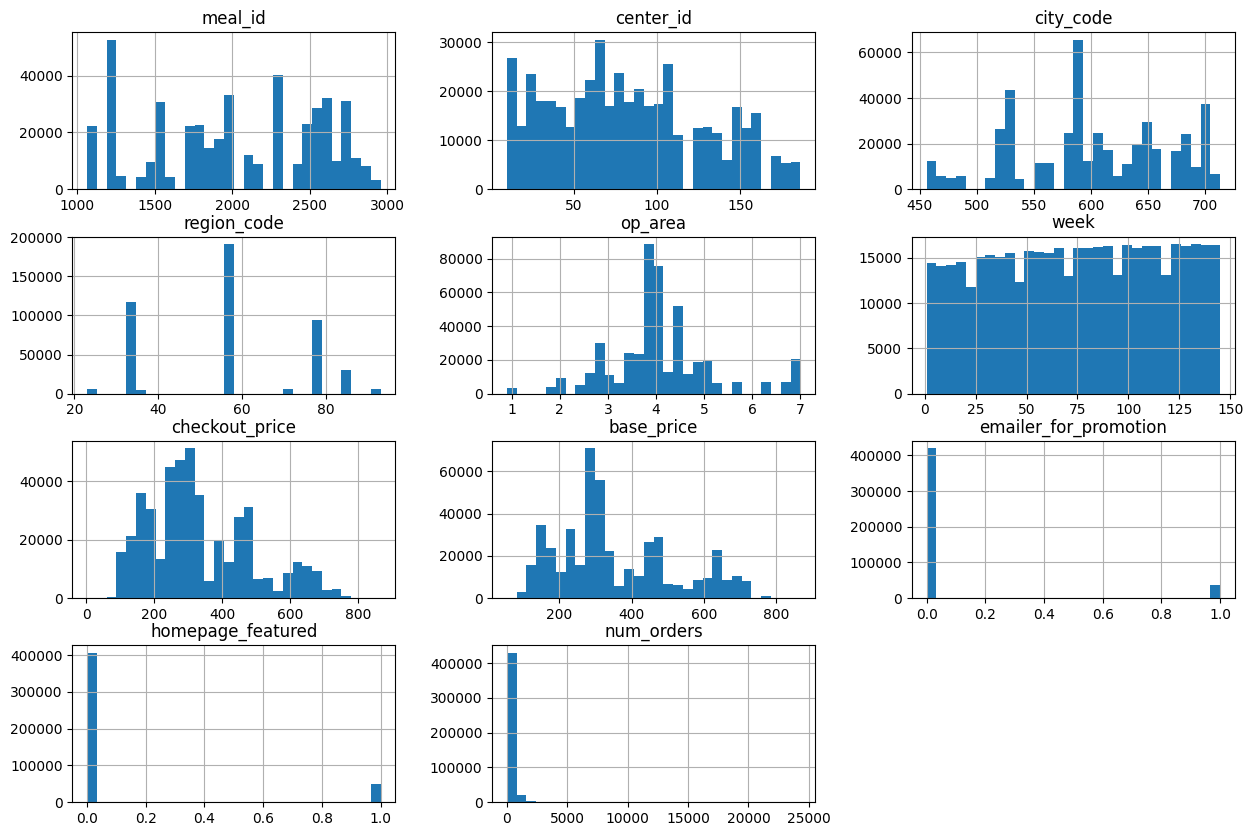

In [ ]:
############# Histogram for numerical features ###########
final_train_df.hist(figsize=(15, 10), bins=30)
plt.show()

#### meal_id
- The distribution is uneven, with certain meal IDs having significantly higher demand than others.
- Some meals are ordered frequently, while others have much lower demand.
#### center_id
- The distribution is somewhat uniform but shows some peaks, indicating that certain centers have more orders than others.
- Some centers receive a significantly higher number of orders.
#### city_code
- The distribution is not uniform, with a few city codes having notably higher order counts.
- Some cities contribute more to the demand, indicating regional preferences.
#### region_code
- The distribution shows clear peaks, indicating that only a few regions dominate food demand.
- Some regions may have significantly lower demand, possibly due to fewer service centers or population differences.
#### op_area (operational area of the center)
- Most centers operate in a mid-range operational area, with fewer in extreme small or large areas.
- Centers with mid-range operational areas tend to have higher demand.
#### week
- Demand slightly increased over time.
#### checkout_price
- There are distinct peaks at certain price points, indicating price clustering.
- Some meals are frequently ordered at specific price ranges, showing customer price sensitivity.
#### base_price
- Similar to checkout_price, there are peaks at certain values.
- This suggests price standardization for certain meals.
#### emailer_for_promotion
- The majority of the values are 0, meaning most meals are not promoted via email.
- A small percentage of meals are promoted, and their effectiveness can be further analyzed.
#### homepage_featured
- Similar to email promotions, most meals are not featured on the homepage.
- A very small fraction of meals get featured, additional study is required to assess its influence on demand.
#### num_orders
- The distribution is highly skewed, with most meals having a low number of orders.
- A small number of meals receive a very high number of orders, indicating popular items.

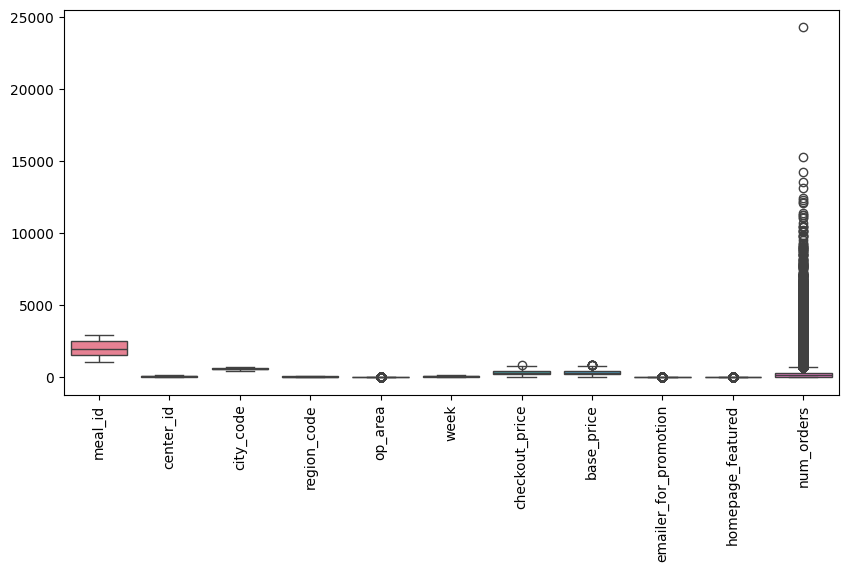

In [ ]:
##################### Boxplot for outlier detection ##################
plt.figure(figsize=(10, 5))
sns.boxplot(data=final_train_df)
plt.xticks(rotation=90)
plt.show()


##### Outliers in num_orders: The num_orders column exhibits a significant number of extreme outliers, indicating that some meals have much higher demand than others.
##### High variance in meal_id: The meal_id column shows a wide interquartile range (IQR), meaning different meal types have varied distributions.
##### Other features are compressed: Most of the other features (such as center_id, region_code, base_price, etc.) have tightly packed boxplots near the bottom, implying less variance compared to num_orders.
##### Skewed distributions: The presence of many outliers suggests that some numerical features might be right-skewed, especially num_orders.
##### Feature scaling needed: Since num_orders dominates the scale, normalization or log transformation may be beneficial before applying machine learning models.

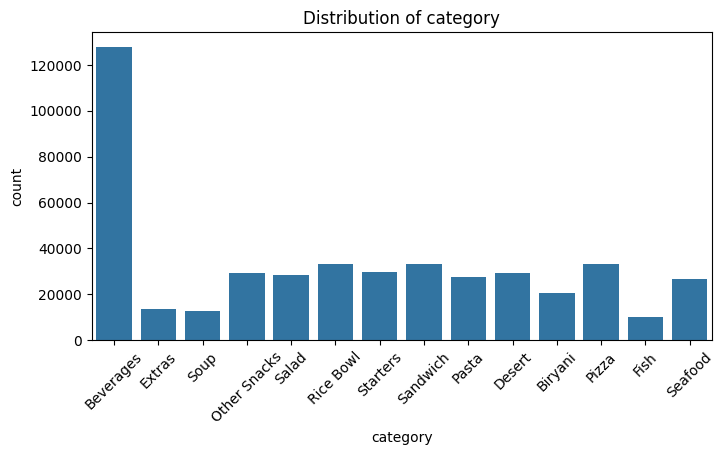

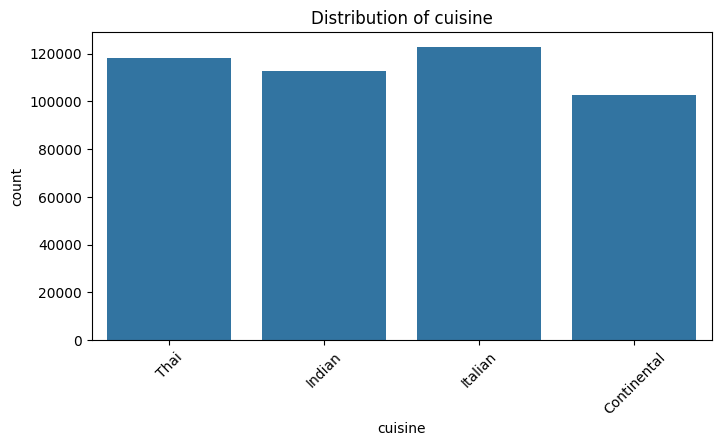

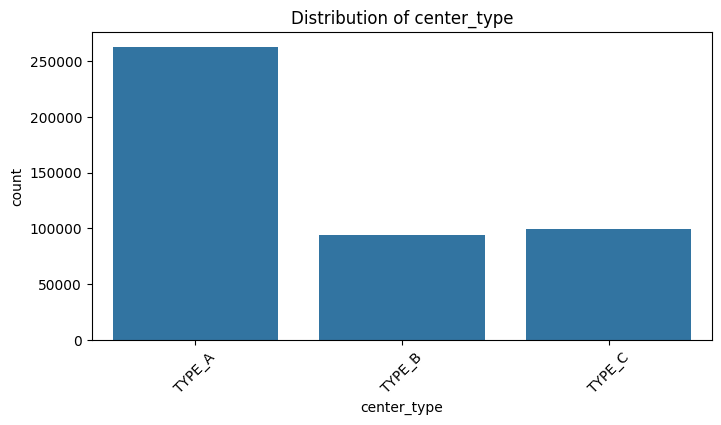

In [ ]:
#################### Count plot for categorical variables #####################
for col in final_train_df.select_dtypes(include="object"):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=final_train_df[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# Bivariate analysis

### Time Series Analysis (Demand over time)

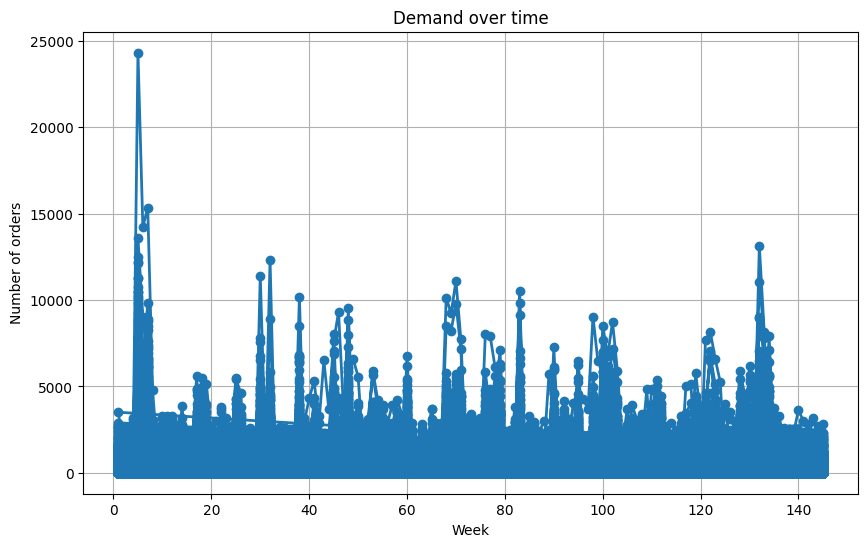

In [ ]:
x= final_train_df['week']
y= final_train_df['num_orders']
plt.figure(figsize=(10,6))
plt.title("Demand over time")
plt.plot(x,y,marker='o', linestyle='-', linewidth=2)
plt.xlabel('Week')
plt.ylabel('Number of orders')
plt.grid(True) #Add grid lines
plt.show()

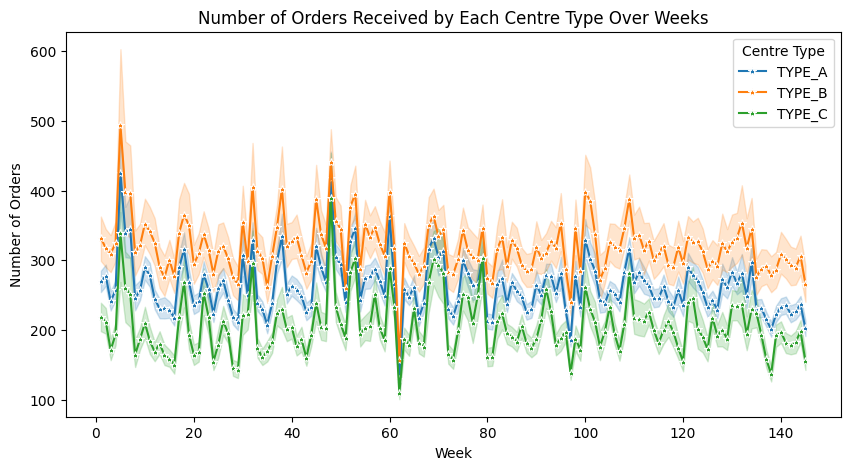

In [44]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Plot the trend for each center type
sns.lineplot(data=final_train_df, x="week", y="num_orders", hue="center_type", marker="*")

# Add labels and title
plt.xlabel("Week")
plt.ylabel("Number of Orders")
plt.title("Number of Orders Received by Each Centre Type Over Weeks")
plt.legend(title="Centre Type")

# Show the plot
plt.show()

### Scatterplot: checkout price Vs number of orders

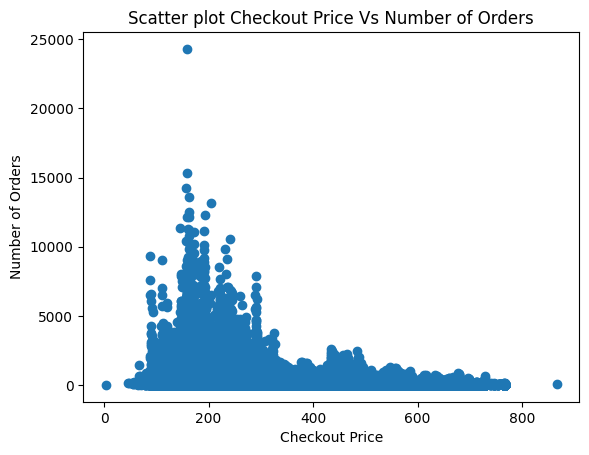

In [ ]:
plt.scatter(final_train_df['checkout_price'], final_train_df['num_orders'])
plt.title('Scatter plot Checkout Price Vs Number of Orders')
plt.xlabel('Checkout Price')
plt.ylabel('Number of Orders')
plt.show()

#### Scatterplot: base price vs checkout price

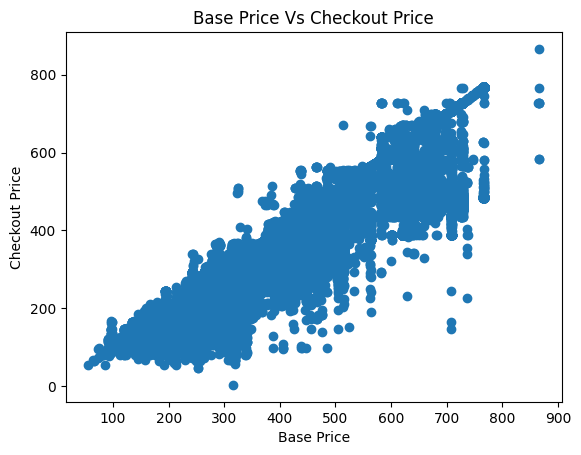

In [ ]:
plt.scatter(final_train_df['base_price'], final_train_df['checkout_price'])
plt.title('Base Price Vs Checkout Price')
plt.xlabel('Base Price')
plt.ylabel('Checkout Price')
plt.show()

### Correlation matrix of numerical columns.

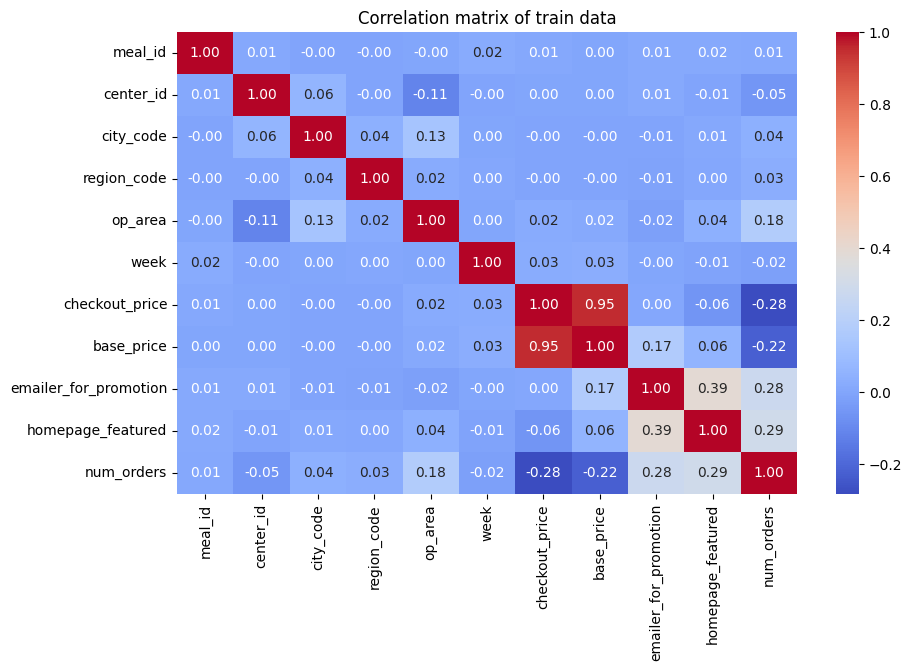

In [ ]:
numeric_train_df = final_train_df.select_dtypes(include=['number'])# Select only numerical columns
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_train_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix of train data")
plt.show()

### Intercollinearity: base price and checkout price have a correlation of 0.95 which is very high.
- It makes it difficult to determine the individual effect of each feature on the target variable.
- It can inflate variance in model coefficients, making them unstable.
- It reduces model interpretability and can lead to overfitting.

### Methods to overcome intercollinearity: 
- Remove One of the Highly Correlated Features
- Use Principal Component Analysis (PCA): Reduces dimensionality while retaining essential information.
- Use Ridge Regression (L2 Regularization):  Reduces feature importance for highly correlated variables instead of completely removing them.
- Feature Engineering (Transforming Variables): 
    - Combining correlated features: Instead of keeping base_price and checkout_price, create a new feature like discount_percentage.
    - Log transformation: Helps reduce correlation and variance in skewed data.


### Using VIF(Variance Inflation Factor) to confirm and quantify the severity of multicollinearity.
| VIF Value | Interpretation                                                           |
|-----------|--------------------------------------------------------------------------|
| VIF < 5   | Low multicollinearity (Safe)                                             |
| VIF 5-10  | Moderate multicollinearity (Investigate further)                         |
| VIF > 10  | High multicollinearity (Remove one of the correlated features)           |


In [42]:
# Selecting only numerical predictor variables
num_cols = final_train_df.drop(columns=["num_orders"]).select_dtypes(include=[np.number])

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = num_cols.columns
vif_data["VIF"] = [variance_inflation_factor(num_cols.values, i) for i in range(len(num_cols.columns))]

# Display VIF values
print(vif_data)

                 Feature        VIF
0                meal_id  13.090517
1              center_id   4.187849
2              city_code  35.623086
3            region_code  10.601662
4                op_area  14.656609
5                   week   4.152813
6         checkout_price  91.992156
7             base_price  96.595982
8  emailer_for_promotion   1.665741
9      homepage_featured   1.391430


### Key Issues in the Data
- checkout_price (VIF = 91.99) and base_price (VIF = 96.60)
    - These two features are highly correlated (probably because base price determines checkout price).
    - Solution: Keep only one of them or use Principal Component Analysis (PCA) to reduce redundancy or create a new feature from them.
- city_code (VIF = 35.62), region_code (VIF = 10.60), and op_area (VIF = 14.66)
    - Possible redundancy among location-related variables.
    - Solution: Use one of them (e.g., keep region_code and drop city_code).
- meal_id (VIF = 13.09)
    - This suggests meal-related features might be strongly correlated.
    - Solution: Consider encoding meal_id differently (e.g., using meal category instead).